Build a baseline model using the weather station data (this approach used all days in 2018 since the data was available).


Then use the model to make predictions for the ENVI-met(micro-climate) data for that specific day and compare it to model predictions using weather station data also for the same day.

# 1. Import

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import pathlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from datetime import datetime
from sklearn import metrics

#  for multicolinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor 

import PyQt5

# 2. Import csv

## 2.1 Microclimate Data

This is the climate of buildings for June 9th only. We will extract weather data for Interdiciplinary AB building only. Data from ENVI-MET. 

In [2]:
microclimate_all = [] # BPS
Fname = []

# 1. Append all building data to microclimate_all (including Inter AB)
for path in pathlib.Path("./Data/BPS").iterdir():
    if path.is_file():
        current_file = pd.read_csv(path)
        microclimate_all.append(current_file)
        Fname.append(path.name.replace('.csv', ''))


# 2. Drop last row (Nan) of microclimate
for i in range(len(microclimate_all)):
    microclimate_all[i] = microclimate_all[i].drop(16)
    
# 3. Get microclimate (interAB only)

# 4. Create empty df for microclimate data of InterAB only
microclimate = pd.DataFrame() 

# 5. Insert temperature data of InterAB building 
microclimate  = microclimate.append(microclimate_all[7])

# 6. Only take the mean and leave the rest
microclimate  = microclimate[['Date','Time', 'AirTempInFrontOfAllFacades_MEAN', 'RelativeAirHumidityInFrontOfAllFacades_MEAN']]

# 7. Rename
microclimate  = microclimate.rename(columns = {'AirTempInFrontOfAllFacades_MEAN':'Air Temp',
                                    'RelativeAirHumidityInFrontOfAllFacades_MEAN':'Rel Humid'})

print(microclimate.shape)
microclimate

(16, 4)


,Date,Time,Air Temp,Rel Humid
0,6/9/2018,5.00.00 AM,29.537667,12.699708
1,6/9/2018,6.00.01 AM,29.033387,16.378229
2,6/9/2018,7.00.01 AM,29.604562,17.250977
3,6/9/2018,8.00.01 AM,31.459578,16.705515
4,6/9/2018,9.00.01 AM,33.820584,14.477529
5,6/9/2018,10.00.01 AM,35.796708,10.969304
6,6/9/2018,11.00.01 AM,36.879628,8.902718
7,6/9/2018,12.00.01 PM,37.837624,7.785688
8,6/9/2018,1.00.01 PM,38.771101,6.989491
9,6/9/2018,2.00.01 PM,39.486798,6.362558


## 2.2 Weather Station

This is the rural climate of Phoenix area. AZ PHX Sky Harbor Data. 

In [3]:
weather_station = pd.read_csv("./Data/Weather Data/KPHX-15.csv") # AZW15
print(weather_station.shape)


(34629, 3)


## 2.3 Building Energy consumption data

This is the energy consumption data of Intediciplinary AB building

In [4]:
building_energy = pd.read_csv("./Data/Weather Data/Interdisciplinary AB 2018.csv")


In [5]:
print(building_energy.shape)
building_energy

(35034, 29)


,campus,bldgno,bldgname,tstamp,Year,Month,Day,Hour,KW,KWS,...,CHWTONgalsgas,HTmmBTU#Houses,HTmmBTUlightbulbs,HTmmBTUgalsgas,Total#Houses,Totallightbulbs,Totalgalsgas,GHG,DOW,tstamp2
0,Tempe,2_3,Interdisciplinary AB,2018-01-01T00:00:00,,,,,138.33,0.00,...,0,0,0,0,41,10156,22,0.019,2,2018-01-01T00:00:00
1,Tempe,2_3,Interdisciplinary AB,2018-01-01T00:15:00,,,,,90.14,0.00,...,0,0,0,0,27,6688,17,0.012,2,2018-01-01T00:15:00
2,Tempe,2_3,Interdisciplinary AB,2018-01-01T00:30:00,,,,,80.49,0.00,...,0,0,0,0,24,6002,16,0.011,2,2018-01-01T00:30:00
3,Tempe,2_3,Interdisciplinary AB,2018-01-01T00:45:00,,,,,84.88,0.00,...,0,0,0,0,25,6289,15,0.012,2,2018-01-01T00:45:00
4,Tempe,2_3,Interdisciplinary AB,2018-01-01T01:00:00,,,,,85.83,0.00,...,0,0,0,0,25,6350,15,0.012,2,2018-01-01T01:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35029,Tempe,2_3,Interdisciplinary AB,2018-12-31T22:45:00,,,,,133.01,0.21,...,0,0,0,0,38,9501,13,0.018,2,2018-12-31T22:45:00
35030,Tempe,2_3,Interdisciplinary AB,2018-12-31T23:00:00,,,,,130.59,0.21,...,0,0,0,0,37,9328,13,0.018,2,2018-12-31T23:00:00
35031,Tempe,2_3,Interdisciplinary AB,2018-12-31T23:15:00,,,,,129.08,0.21,...,0,0,0,0,37,9220,12,0.018,2,2018-12-31T23:15:00
35032,Tempe,2_3,Interdisciplinary AB,2018-12-31T23:30:00,,,,,131.71,0.22,...,0,0,0,0,38,9408,13,0.018,2,2018-12-31T23:30:00


# 3. Preprocessing

## 3.1 Formatting Date and Time

### a) Microclimate Dates

In [6]:
# 1. format time
microclimate['Time'] = microclimate['Time'].str.replace('.',':')
microclimate['Time'] = microclimate['Time'].str.replace('01','00')

# convert to 24 hour format
microclimate['Time'] = pd.to_datetime(microclimate['Time']).dt.strftime('%H:%M')


<ipython-input-6-f3b6d8f03342>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  microclimate['Time'] = microclimate['Time'].str.replace('.',':')


In [7]:
# 2. format date (still in string)
microclimate['Date'] = pd.to_datetime(microclimate['Date']).dt.strftime('%m/%d/%Y')

In [8]:
# 3. combine date time column as string and set as index
microclimate['Date_Time'] = microclimate['Date'] + ' ' + microclimate['Time']

In [9]:
# 4. Get string type for month and time
microclimate['Month'] = microclimate['Date_Time'].str[0:2]
microclimate['Time'] = microclimate['Time'].str.replace(':','')

In [10]:
# # 5. Get numeric for month hour and minute
# microclimate.Date_Time = pd.to_datetime(microclimate.Date_Time)
# microclimate['Month_num'] = microclimate.Date_Time.dt.month
# microclimate['Hour_num'] = microclimate.Date_Time.dt.hour
# microclimate['Minute_num'] = microclimate.Date_Time.dt.minute
# microclimate.Date_Time = pd.to_datetime(microclimate.Date_Time).dt.strftime('%m/%d/%Y %H:%M')
# # 6. Rearrange columns
# print(list(microclimate.columns))
# microclimate = microclimate[['Date_Time','Month','Time','Month_num', 'Hour_num', 'Minute_num', 'Air Temp', 'Rel Humid' ]]

In [11]:
# 5. Rearrange columns
print(list(microclimate.columns))
microclimate = microclimate[['Date_Time','Month','Time', 'Air Temp', 'Rel Humid' ]]

['Date', 'Time', 'Air Temp', 'Rel Humid', 'Date_Time', 'Month']


In [12]:
microclimate = microclimate.set_index('Date_Time')

### b) Weather Station dates

In [13]:
# 1. Get string type for month and time
weather_station['Month'] = weather_station['Date_Time'].str[0:2]
weather_station['Time'] = weather_station['Date_Time'].str[11:]
weather_station['Time'] = weather_station['Time'].str.replace(':','')

In [14]:
# 2. Get numeric for month hour and minute
weather_station.Date_Time = pd.to_datetime(weather_station.Date_Time)
weather_station['Month_num'] = weather_station.Date_Time.dt.month
weather_station['Hour_num'] = weather_station.Date_Time.dt.hour
weather_station['Minute_num'] = weather_station.Date_Time.dt.minute
weather_station.Date_Time = pd.to_datetime(weather_station.Date_Time).dt.strftime('%m/%d/%Y %H:%M')

In [15]:
# 4. set date time as index
weather_station = weather_station.set_index('Date_Time') 


### c) Building energy dates

In [16]:
building_energy.tstamp =  pd.to_datetime(building_energy.tstamp).dt.strftime('%m/%d/%Y %H:%M')

In [17]:
# remove unwanted columns
building_energy = building_energy[['tstamp','KW', 'CHWTON']]

In [18]:
# set date time as index
building_energy = building_energy.set_index('tstamp')


## 3.2 Append Energy Consumption to Weather Station data

In [19]:
weather_station =  pd.concat([building_energy, weather_station], axis = 1, join = "inner")


In [20]:
# rearrange column
weather_station = weather_station[['Month','Time','Month_num', 'Hour_num', 'Minute_num', 'Air Temp', 'Rel Humid', 'KW','CHWTON' ]]
weather_station 

,Month,Time,Month_num,Hour_num,Minute_num,Air Temp,Rel Humid,KW,CHWTON
01/01/2018 00:00,01,0000,1,0,0,11.0,40.24,138.33,1.09
01/01/2018 00:15,01,0015,1,0,15,11.0,40.24,90.14,0.99
01/01/2018 00:30,01,0030,1,0,30,10.0,43.01,80.49,1.01
01/01/2018 00:45,01,0045,1,0,45,9.0,46.00,84.88,0.90
01/01/2018 01:00,01,0100,1,1,0,9.0,46.00,85.83,0.87
...,...,...,...,...,...,...,...,...,...
12/31/2018 22:00,12,2200,12,22,0,6.0,93.30,124.28,0.00
12/31/2018 22:15,12,2215,12,22,15,5.0,100.00,127.61,0.00
12/31/2018 22:30,12,2230,12,22,30,5.0,100.00,130.48,0.00
12/31/2018 22:45,12,2245,12,22,45,6.0,93.30,133.01,0.00


In [21]:
weather_station.to_csv('./Data/weather_st')

# 4. Create June 9th Data 

For both microclimate and weather_station

## 4.1 For Microclimate

We want: month, hour, minute, CHWTON, KW, date, air temp, and real humidity for microclimate June 9th.
We do this by merging with building_energy to get KW and CHWTON on the dates that appear in microclimate data



In [22]:
microclimate_June_9 = pd.merge(microclimate, building_energy, left_index = True, right_index = True)
microclimate_June_9

,Month,Time,Air Temp,Rel Humid,KW,CHWTON
06/09/2018 05:00,06,0500,29.537667,12.699708,93.54,2.08
06/09/2018 06:00,06,0600,29.033387,16.378229,117.23,1.22
06/09/2018 07:00,06,0700,29.604562,17.250977,103.66,1.36
06/09/2018 08:00,06,0800,31.459578,16.705515,106.36,2.67
06/09/2018 09:00,06,0900,33.820584,14.477529,105.26,2.71
06/09/2018 10:00,06,1000,35.796708,10.969304,103.63,3.53
06/09/2018 11:00,06,1100,36.879628,8.902718,105.14,4.02
06/09/2018 12:00,06,1200,37.837624,7.785688,103.65,5.69
06/09/2018 13:00,06,1300,38.771101,6.989491,105.62,4.84
06/09/2018 14:00,06,1400,39.486798,6.362558,102.44,4.79


## 4.2 For WeatherStation

In [23]:
# 1. Extract june 9th data 
weather_st_June_9 = weather_station.iloc[15150:15246]

# 2. Filter time ( only minute 00)
weather_st_June_9 = weather_st_June_9[ (weather_st_June_9['Hour_num'] >= 5) & (weather_st_June_9['Hour_num'] <= 20) & (weather_st_June_9['Minute_num'] == 0)]

In [24]:
# 3. drop June 9th data on original data
weather_station = weather_station.drop(weather_station.index[15150:15246])

# 4. drop Hour_num and minute_num
weather_station = weather_station.drop(labels = ['Hour_num', 'Month_num','Minute_num'], axis = 1)
weather_st_June_9 = weather_st_June_9.drop(labels = ['Hour_num', 'Month_num','Minute_num'], axis = 1)

In [25]:
weather_st_June_9

,Month,Time,Air Temp,Rel Humid,KW,CHWTON
06/09/2018 05:00,06,0500,27.0,14.84,93.54,2.08
06/09/2018 06:00,06,0600,26.0,15.74,117.23,1.22
06/09/2018 07:00,06,0700,28.0,17.42,103.66,1.36
06/09/2018 08:00,06,0800,31.0,11.78,106.36,2.67
06/09/2018 09:00,06,0900,33.0,9.06,105.26,2.71
06/09/2018 10:00,06,1000,35.0,7.52,103.63,3.53
06/09/2018 11:00,06,1100,37.0,6.74,105.14,4.02
06/09/2018 12:00,06,1200,39.0,5.19,103.65,5.69
06/09/2018 13:00,06,1300,41.0,4.32,105.62,4.84
06/09/2018 14:00,06,1400,41.0,3.99,102.44,4.79


In [26]:
# 5. convert index to date time object
weather_station.index = pd.to_datetime(weather_station.index)

# 6. ensure theres no more june 9th data on weather_station data
print(weather_station[(weather_station.index.month == 6) & (weather_station.index.day == 9)])

# convert back
# weather_station.index = pd.to_datetime(weather_station.index).dt.strftime('%m/%d/%Y %H:%M')

Empty DataFrame
Columns: [Month, Time, Air Temp, Rel Humid, KW, CHWTON]
Index: []


In [27]:
print(weather_station.shape)
print(list(weather_station.columns))


(34527, 6)
['Month', 'Time', 'Air Temp', 'Rel Humid', 'KW', 'CHWTON']


# 5. EDA

## 5.1 Correlation Matrix

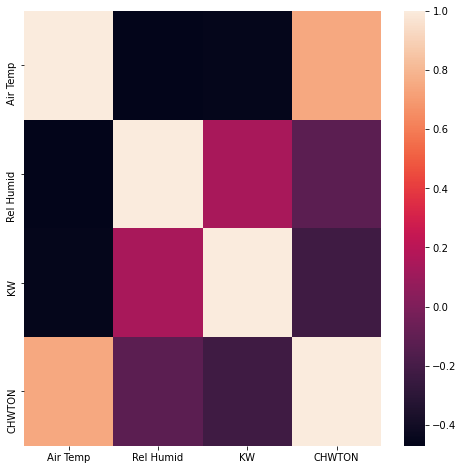

In [28]:
corrMatrix = weather_station.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corrMatrix)
plt.show()

## 5.2 Multicolinearity

A simple method to detect multicollinearity in a model is by using something called the variance inflation factor or the VIF for each predicting variable. An acceptable VIF is if it’s less than the max of 10

In [29]:
## Get X
Y = weather_station['CHWTON']

## Get Y
X = weather_station.drop(labels = ['CHWTON'], axis = 1)

In [30]:
X_int = X.drop(labels = ['Month', 'Time'], axis = 1)

In [31]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_int.columns
vif_data["VIF"] = [variance_inflation_factor(X_int.values, i) for i in range(len(X_int.columns))]

In [32]:
vif_data

,feature,VIF
0,Air Temp,3.925219
1,Rel Humid,3.273488
2,KW,6.620458


# 6. Modelling

Scoring:
One one hand, RMSE tells us the typical distance between the predicted value made by the regression model and the actual value.

On the other hand, R2 tells us how well the predictor variables can explain the variation in the response variable.

## 6.1 train & predict

In [33]:
############################ RANDOM FORESTS #################################

# 1. Get train test 
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

# 2. Using RandomForestRegressor to make predictions
from sklearn.ensemble import RandomForestRegressor
# - string
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, Y_train)

# 3. Get prediction
Y_pred = model.predict(X_test)
ModelPred = pd.DataFrame({'Actual CHWTON':Y_test, 'Predicted CHWTON':Y_pred})
ModelPred = ModelPred.sort_index()
print(ModelPred)

                     Actual CHWTON  Predicted CHWTON
2018-01-01 00:15:00           0.99            2.5217
2018-01-01 00:30:00           1.01            1.1789
2018-01-01 00:45:00           0.90            0.8819
2018-01-01 02:00:00           1.06            1.0375
2018-01-01 03:15:00           0.92            0.7448
...                            ...               ...
2018-12-31 17:30:00           0.00            0.0000
2018-12-31 18:45:00           0.00            0.0000
2018-12-31 22:15:00           0.00            0.0051
2018-12-31 22:45:00           0.00            0.0000
2018-12-31 23:00:00           0.00            0.0006

[6906 rows x 2 columns]


## 6.2 Score

In [34]:
# 1. RMSE and R2
R2_all = model.score(X_test, Y_test)
RMSE_all = np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))

# 2.Feature importance
feature_list = list(X_train.columns)
feature_imp = pd.Series(model.feature_importances_, index=feature_list).sort_values(ascending=False)
print("\033[1m" + "Feature Importances:" + "\033[0m")
print(feature_imp, "\n")


Feature Importances:
Air Temp     0.539102
Month        0.251560
Time         0.123118
KW           0.046696
Rel Humid    0.039524
dtype: float64 



In [35]:
# 3. create score df
scores_df = pd.DataFrame({"score_type": ["R2", "RMSE"], "RF_allyear": [R2_all, RMSE_all]})
scores_df

,score_type,RF_allyear
0,R2,0.937572
1,RMSE,0.896675


# 7. June 9th Prediction

## 7.1 Weather Station prediction

In [36]:
# 1. Get X and Y (all test)
X_J9 = weather_st_June_9.drop(labels = ['CHWTON'], axis = 1)

# 2. Get Y
Y_actual_J9 = weather_st_June_9['CHWTON']

# 3. Get Y_pred
Y_pred_J9 = model.predict(X_J9)

# 4. Score
R2_J9 = model.score(X_J9, Y_actual_J9)
RMSE_J9 = np.sqrt(metrics.mean_squared_error(Y_actual_J9, Y_pred_J9))

# 5. Append score to df
score_J9_AZ = [R2_J9, RMSE_J9]
scores_df['RF_J9_AZ'] = score_J9_AZ

scores_df

,score_type,RF_allyear,RF_J9_AZ
0,R2,0.937572,0.876395
1,RMSE,0.896675,0.491681


## 7.2 Microclimate prediction

In [38]:
# 1. Get X
X_J9_micro = microclimate_June_9.drop(labels = ['CHWTON'], axis = 1)

# 2. Get Y_pred
Y_pred_J9_micro = model.predict(X_J9_micro)

# 3. Score
R2_J9_micro = model.score(X_J9_micro, Y_actual_J9)
RMSE_J9_micro = np.sqrt(metrics.mean_squared_error(Y_actual_J9, Y_pred_J9_micro))

# 4. append to score df
score_J9_micro = [R2_J9_micro, RMSE_J9_micro]
scores_df['RF_J9_micro'] = score_J9_micro
scores_df

,score_type,RF_allyear,RF_J9_AZ,RF_J9_micro
0,R2,0.937572,0.876395,0.854341
1,RMSE,0.896675,0.491681,0.533744


In [39]:
Pred = pd.DataFrame({'Actual':Y_actual_J9,'Baseline Predictions (AZW)': Y_pred_J9, 'Microclimate Predictions': Y_pred_J9_micro})
Pred

,Actual,Baseline Predictions (AZW),Microclimate Predictions
06/09/2018 05:00,2.08,1.5679,2.0772
06/09/2018 06:00,1.22,1.2942,1.6508
06/09/2018 07:00,1.36,1.9569,2.2588
06/09/2018 08:00,2.67,2.6329,2.7653
06/09/2018 09:00,2.71,2.5130,3.3947
06/09/2018 10:00,3.53,3.4021,3.8163
06/09/2018 11:00,4.02,4.1991,4.1377
06/09/2018 12:00,5.69,4.2866,4.4807
06/09/2018 13:00,4.84,4.9148,4.6785
06/09/2018 14:00,4.79,5.0062,4.8188


# 8. Hypothesis Test

([<matplotlib.axis.XTick at 0x7fc9d6bcefa0>,
 [Text(1, 0, 'Baseline_pred'), Text(2, 0, 'Microclimate_pred')])

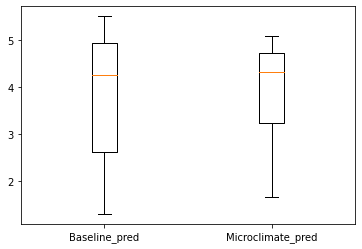

In [40]:
plt.boxplot([Y_pred_J9,Y_pred_J9_micro])
plt.xticks([1,2],['Baseline_pred', 'Microclimate_pred'])

In [41]:
print(Y_pred_J9.mean())
print(Y_pred_J9_micro.mean())
print('mu:', Y_pred_J9.mean()- Y_pred_J9_micro.mean())

3.8306562500000005
3.866331250000001
mu: -0.035675000000000345


## Two-Sample T Test


mean differences in CHWTON = $ \mu_{baseline} - \mu_{microclimate} = 3.83065-3.866 = -0.03567 $ 

$ H_0: $ Mean of CHWTON in baseline and microclimate are the same

$ H_1: $ Mean of CHWTON in baseline and microclimate are NOT the same

## 8.1 calculate standard deviation

In [42]:
# 1.variance
var_baseline = Y_pred_J9.var(ddof = 1)
var_micro = Y_pred_J9_micro.var(ddof = 1)
print(var_baseline, var_micro)

2.050340138625001 1.2513453529583354


In [43]:
# 2. standard deviation
s = np.sqrt((var_baseline + var_micro)/2)
s

1.2848512543449022

## 2. calculate T-statistic

In [44]:
import scipy.stats as stats
t_stat, p_val = stats.ttest_ind(Y_pred_J9, Y_pred_J9_micro, equal_var=False)
print('t statistics: ', t_stat)
print('p value: ', p_val)

t statistics:  -0.07853371145811627
p value:  0.9379554031790899


P value is not less that 0.05. We cannot reject the null hypothesis. There is no significant difference between the transaction amount of fraud and non fraudulent transaction

# 9. Plot

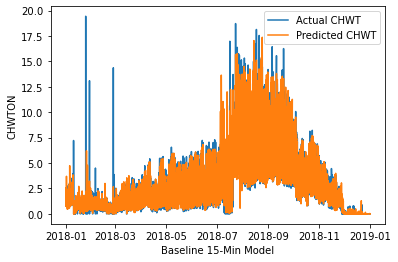

In [45]:
####### Plotting Baseline Model for all 2018 15-min Data #######

## This is a big graph, will be slow to run but gives visual of prediction accuracy
# %matplotlib qt
plt.xlabel('Baseline 15-Min Model')
plt.ylabel('CHWTON')
plt.plot(ModelPred['Actual CHWTON'], label = 'Actual CHWT')
plt.plot(ModelPred['Predicted CHWTON'], label = 'Predicted CHWT')
plt.legend()
plt.show()

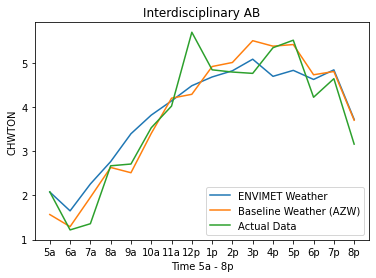

In [46]:
#  Plotting ENVI-met vs AZW vs Actual Data for June 9 from 5a - 8p

positions = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
labels = ['5a', '6a', '7a', '8a', '9a', '10a', '11a', '12p', '1p', '2p', '3p', '4p', '5p', '6p', '7p', '8p']

# plot EnviMet vs AZ_Weather results
plt.xlabel('Time 5a - 8p')
plt.ylabel('CHWTON')
plt.xticks(positions, labels)
plt.plot(Pred['Microclimate Predictions'], label = 'ENVIMET Weather')
plt.plot(Pred['Baseline Predictions (AZW)'], label = 'Baseline Weather (AZW)')
plt.plot(Pred['Actual'], label = 'Actual Data')
plt.title('Interdisciplinary AB')
plt.legend()

## show graphs
plt.show()

# 10. Save DF

## 10.1 Weather Station string


In [47]:
weather_station.to_csv('./Data/weather_st2')

## 10.2 June 9th Weather St


In [48]:
weather_st_June_9.to_csv('./Data/weather_j9')

In [49]:
scores_df.to_csv('./Data/score')